In [1]:
# Imports
import os
import random
import shutil
import json

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall

from keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [2]:
# Variables
image_per_class = 1000;
image_size = (254, 254);
image_shape = (254, 254, 3);

epoch = 10;
batch_size = 32;

In [3]:
# Install kaggle library
!pip install kaggle

In [4]:
# Set the kaggle directory to /content
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [5]:
# Download the datasets
!kaggle datasets download -d sadmansakibmahi/plant-disease-expert

Dataset URL: https://www.kaggle.com/datasets/sadmansakibmahi/plant-disease-expert
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
plant-disease-expert.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip the datasets
zip_file_path = "/content/plant-disease-expert.zip"
unzip_dir_path = "/content/plant-disease/"

if not os.path.exists(unzip_dir_path):
  !unzip /content/plant-disease-expert.zip -d /content/plant-disease/

In [7]:
# Pick tomato folder only from dataset and trim the datasets into 1000 images each class
source_dir = '/content/plant-disease/Image Data base/Image Data base/'
dest_dir = '/content/plant-tomato/'

random_seed = 42

random.seed(random_seed)

def makeDataset():
  chosen_folders = [
      'Tomato Spider mites Two spotted spider mite',
      'Tomato Bacterial spot',
      'Tomato Septoria leaf spot',
      'Tomato healthy',
      'Tomato Target Spot',
      'Tomato Late blight',
      'Tomato Early blight',
      'Tomato Tomato mosaic virus',
      'Tomato Leaf Mold',
  ]

  for class_name in chosen_folders:
      subdir = os.path.join(source_dir, class_name)

      if os.path.exists(subdir):
          all_files = [f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]

          dest_class_dir = os.path.join(dest_dir, class_name)
          os.makedirs(dest_class_dir, exist_ok=True)

          for file in random.sample(all_files, min(image_per_class, len(all_files))):
              src_path = os.path.join(subdir, file)
              dest_path = os.path.join(dest_class_dir, file)
              shutil.copy(src_path, dest_path)

      else:
          print(f"Folder {class_name} does not exist in {source_dir}")

if os.path.exists(dest_dir) and os.path.isdir(dest_dir):
    print("Tomato directory already exists")
else:
    os.makedirs(dest_dir, exist_ok=True)
    makeDataset()

Tomato directory already exists


In [8]:
# Splitting the datasets into 80% for training, 10% for validation and 10% for testing

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/plant-tomato',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset='training',
    seed=42,
    verbose=0
)

dummy_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/plant-tomato',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset='validation',
    seed=42,
    verbose=0
)

dummmy_size = int(0.5 * len(dummy_ds))
val_ds, test_ds = dummy_ds.take(dummmy_size), dummy_ds.skip(dummmy_size)

Using 7200 files for training.
Using 1800 files for validation.


In [9]:
# Creating the base model
base_model = tf.keras.applications.EfficientNetB3(
    input_shape=image_shape,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True

x = base_model.output
x = Dense(512, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=.5, seed=42)(x)
output = Dense(9, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 254, 254, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 254, 254, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 254, 254, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 254, 254, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 255, 255, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 127, 127, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 127, 127, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 127, 127, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 127, 127, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 127, 127, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 127, 127, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 11,575,096 (44.16 MB)

 Trainable params: 11,487,793 (43.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [10]:
# Compling the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 216s 382ms/step - accuracy: 0.5274 - loss: 1.3652 - val_accuracy: 0.9464 - val_loss: 0.1595
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 116s 337ms/step - accuracy: 0.9525 - loss: 0.1476 - val_accuracy: 0.9799 - val_loss: 0.0553
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 334ms/step - accuracy: 0.9778 - loss: 0.0697 - val_accuracy: 0.9911 - val_loss: 0.0261
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 336ms/step - accuracy: 0.9903 - loss: 0.0286 - val_accuracy: 0.9911 - val_loss: 0.0257
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 334ms/step - accuracy: 0.9932 - loss: 0.0242 - val_accuracy: 0.9911 - val_loss: 0.0264
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 333ms/step - accuracy: 0.9907 - loss: 0.0334 - val_accuracy: 0.9866 - val_loss: 0.0559
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 336ms/step - accuracy: 0.9939 - loss: 0.0182 - val_accuracy: 0.9900 - val_loss: 0.0242
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 334ms/step - accuracy: 0.9943 - loss:

In [12]:
result = model.evaluate(test_ds)
print("Test Loss: ", result[0])
print("Test Accuracy: ", result[1])

29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.9926 - loss: 0.0299
Test Loss:  0.03883448615670204
Test Accuracy:  0.9900442361831665


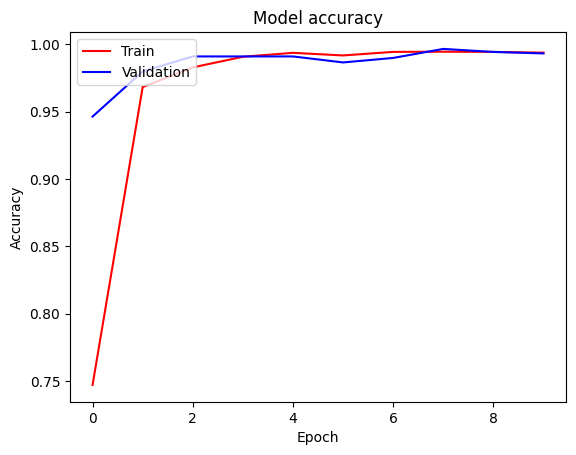

In [13]:
# Plotting Graphs - Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


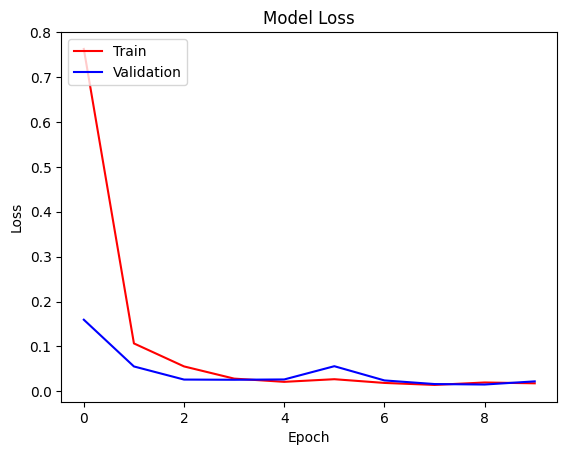

In [14]:
# Plotting Graphs - Loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Predict the images on test dataset
correct = 0
total = 0

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    correct += np.sum(predicted_labels == labels)
    total += labels.shape[0]

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━

In [16]:
# Save the model and class names
class_names = train_ds.class_names
class_names_file = 'class_names.json'
with open(class_names_file, 'w') as f:
    json.dump(class_names, f)

model.save("PlantTomatoDisease.h5")
print(f"Model saved as PlantTomatoDisease.h5 and Class names saved to {class_names_file}")

Model saved as PlantTomatoDisease.h5 and Class names saved to class_names.json
